# Classification of windowed time series **without** feature extraction

Here we will make use of the processed data before using feature extraction methods to expand our data into higher dimensional space. 

In the following cells we will use the original features to build and evaluate classifiers for
* binary (Sleep / Wake), 
* three (Sleep / NREM / REM), 
* and multi (Sleep / N1 / N2 / N3 / REM) label classification.

## AutoML

Automated machine learning (AutoML) involves automating the process of applying machine learning end-to-end. It makes ML accessible to non-experts as well as providing a quick and easy way to create model fitted on data without worrying about hyperparameters.

We will use AutoML later on in the notebook but we are installing it here because the runtime must be restarted afterwards.

***Note if you are running this book: run this cell, then restart the notebook's runtime and then run all cells again after. This avoids version errors in auto-sklearn modules.***

In [ ]:
!apt-get install swig -y
!pip install Cython numpy

# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


### Mount Drive 





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CA4015/sleep_classify')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Modelling the Windows as Independent Data Points**##

This next part of the notebook involves looking at the interpolated data chunks as independent separate data points with the time element and patient ID removed. The model performance from this dataset will be a true indicator of how important the time series element is to classifying a patient's sleep state, given only their motion and heart rate for that given window. It's expected that this will result in an impaired model performance compared to the classification of the data with extracted features. Although an improvement would lead to the hypothesis that sleep classification only requires a static model of independent data points.

## Read in our windowed features and their matching labels prepared in our previous data processing

In this approach we are using the original motion and heart rate features that were windowed at the end of our data processing operation. The time and ID columns are dropped from the dataframe as we are modelling purely based on the heart rate and motion features.

In [ ]:
import pandas as pd
import numpy as np
# read in our windowed features and matching labels

full_set_features = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_features.csv')
full_set_true_labels = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_labels.csv')

# we do not require id and time step columns for this approach
full_set_features = full_set_features.drop(['Unnamed: 0', 'id'], axis=1)
full_set_true_labels = full_set_true_labels.drop(['0', 'id'], axis=1)


Ensure that the unique labels for our data lie in the range 0-5 with unknowns -1 and 4 removed.

In [ ]:
full_set_true_labels["1"].unique()

array([0, 1, 2, 3, 5])

Notice the new dataframe where the order and index of data points are arbitrary and provide no information about the given readings.

In [ ]:
print("Full Set Features", "\n", full_set_features)
print("\nFull Set Labels", "\n", full_set_true_labels)

Full Set Features 
               x         y         z    hr
0     -0.612717 -0.086441 -0.774131  74.5
1     -0.608009 -0.078117 -0.779465  66.5
2     -0.608291 -0.074685 -0.776802  68.0
3     -0.604043 -0.074944 -0.782837  71.0
4     -0.607269 -0.070290 -0.782433  68.0
...         ...       ...       ...   ...
26412 -0.108566 -0.196350 -0.966415  87.0
26413 -0.106613 -0.198547 -0.966125  87.0
26414 -0.108292 -0.198059 -0.967621  87.0
26415 -0.107285 -0.199288 -0.968819  86.5
26416 -0.106293 -0.197815 -0.970017  87.0

[26417 rows x 4 columns]

Full Set Labels 
        1
0      0
1      0
2      0
3      0
4      0
...   ..
26412  2
26413  2
26414  2
26415  2
26416  2

[26417 rows x 1 columns]


Classification models require the target feature set to be in a numpy array. Here we unravel our labels from pandas Series format into a numpy array.

In [ ]:
label_array = full_set_true_labels.values.ravel()
print(label_array.shape)
label_array

(26417,)


array([0, 0, 0, ..., 2, 2, 2])

# **Sklearn - Binary Data Classifier**

First, we will attempt to classify the data points as being either "Wake" or "Sleep". The next cell will create a dataset which will replace any label greater than 0 with a 1, so 0 still represents "Wake", while 1 represents "Sleep".

Let's now implement a simple classifier using our new **binary** dataset.

In [ ]:
# first we'll create a binary label set, indicating 0 for awake and 1 for asleep

binary_label_array = label_array.copy()
binary_label_array[binary_label_array > 0] = 1
np.unique(binary_label_array)

array([0, 1])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(full_set_features, binary_label_array, test_size=0.25)

## Support Vector Machine (SVM)

SVMs are a type of supervised learning model that attempts to analyse input data given corresponding labels. SVMs are quite robust but unfortunately training complexity can reach $O(n2p+n3)$ when using non-approximate or non-linear kernels, where $n$ is the number of training examples and $p$ is the number of features.

SVMs work by finding a separating hyperplane between data of different classes. SVM is an algorithm that takes the data as an input and outputs a line that separates those classes as best as it can.

A hyperplane in an n-dimensional Euclidean space is a flat, n-1 dimensional subset of that space that divides the space into two disconnected parts.

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Implementing a C-Support Vector Classifier, 

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
clf.score(X_test, y_test, sample_weight=None)

0.9032551097653293

Not a bad score, but as we will see later on, not the best score. Also, accuracy alone is not the best representation of model performance. We would expect the performance to be quite high for binary classification, as a human randomly guessing the label would be 50% accurate.

## Decision Tree Classifier

Let's look at the consistency of our classifier according to this Decision Tree Model. We can see below it is ~90% accurate with 95% confidence interval of 1%.

To train our model we use a technique called Cross Validation; by partitioning the available data into n sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets. 

The confusion matrix below shows how the decision tree performed on the test set. The top left entry indicates the number of examples correctly labelled "Wake" and the top right is the number of examples incorrectly labelled as "Sleep". Then the bottom left and right indicate the number of examples were incorrectly labelled "Wake" and correctly labelled "Sleep" respectively.

The smaller the values off the diagonal of your confusion matrix are, the better it has performed on the given data.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=0)  # min_samples_leaf=200

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [full_set_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("\nimportance\n", importance)

predictions = clf.predict(X_test)
print("\nTest set accuracy:\n", accuracy_score(y_test, predictions), "\n")
print("Confusion Matrix\n", confusion_matrix(y_test, predictions), "\n")

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.91 (+/- 0.01)

The list of features with importance: 
['x', 'y', 'z', 'hr']

importance
 [0.27379059 0.27867296 0.2858144  0.16172205]

Test set accuracy:
 0.9091597274791824 

Confusion Matrix
 [[ 343  306]
 [ 294 5662]] 



## Interpreting our models

The advantage of using more "basic" models like Decsion Trees is that they are much easier to interpret than more complex approaches such as neural networks. This is particularly important in real-world scenarios where a model is used to make high-stakes decisions; we want to know **why** a model has made a particular decision when given an input - such as a patient's MRI scan - not just **how**. [A paper published in Nature](https://www.nature.com/articles/s42256-019-0048-x) explores this topic further.

In our case, it's not critical to know why a model has made a classification, but it is interesting to note that Decision Trees perform quite well on this data.

In the below cells we can project the Decision Tree on to an image, which would allow a human to follow the "thought process" of the model from start to classification given an input.

The resulting image from the above tree is far too large to see here, but if we set the parameter min_samples_leaf to a large value such as 200, it would force the tree to stop splitting earlier, making the image simpler and easier to read. However, doing so creates an issue which we will see later on, whereby the model simply guesses that all given inputs are classified as "Sleep", because that is the majority label it is shown in training.

In [ ]:
!pip install graphviz
!pip install imageio
import graphviz
import pydotplus
import io
from scipy import misc
import imageio
import matplotlib.pyplot as plt


def show_tree(tree, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = imageio.imread(path)
    plt.rcParams["figure.figsize"] = (30,20)
    plt.imshow(img)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.546955 to fit



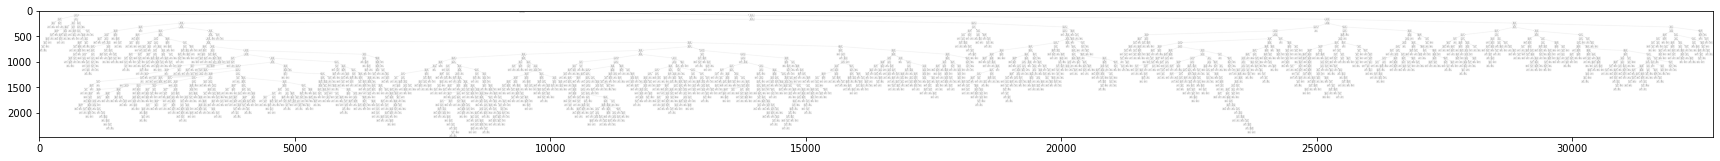

In [ ]:
show_tree(clf, "binary_dec_tree.png")

## Comparing Classification Algorithms

When comparing the different algorithms for classifying our sleep stages, we must also look at how these algorithms choose a label. As shown below, all algorithms initially look very effective at classifying data, with all achieving accuracy of $>= 90%$. 

However, a closer inspection reveals that some algorithms are simply guessing every datapoint is in "Sleep" stage, because, for the majority of our points, this is true.

In [ ]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

def algorithm_comparison(X_train, y_train, X_test, y_test, n_splits=10):
    models = []
    models.append(("LOGISTIC REGRESSION", LogisticRegression()))
    models.append(("LINEAR DISCRIMINANT AANALYSIS", LinearDiscriminantAnalysis()))
    models.append(("K NEAREST NEIGHBOURS", KNeighborsClassifier()))
    models.append(("NAIVE BAYES", GaussianNB()))
    models.append(("DECISION TREE", DecisionTreeClassifier()))
    models.append(("RANDOM FOREST", RandomForestClassifier()))
    models.append(("SUPPORT VECTOR MACHINE", SVC()))
    models.append(("ADABOOST CLASSIFIER", AdaBoostClassifier()))

    results = []
    names = []

    for name, model in models:
      kfold = model_selection.KFold(n_splits=n_splits)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
      results.append(cv_results)
      names.append(name)
      print("Model  Mean Accuracy  95% conf interval")
      msg = "{}: {} {}\n".format(name, cv_results.mean(), cv_results.std() * 2)
      print(msg)

      model.fit(X_train, y_train)
      predictions = model.predict(X_test)
      print("Test set accuracy:\n", accuracy_score(y_test, predictions), "\n")
      print("Confusion Matrix\n", confusion_matrix(y_test, predictions), "\n")
      print("Classification report\n" ,classification_report(y_test, predictions), "\n")

    return names, results


In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.9101554831443618 0.01457385301855638

Test set accuracy:
 0.9017411052233156 

Confusion Matrix
 [[   0  649]
 [   0 5956]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       649
           1       0.90      1.00      0.95      5956

    accuracy                           0.90      6605
   macro avg       0.45      0.50      0.47      6605
weighted avg       0.81      0.90      0.86      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.9101554831443618 0.01457385301855638

Test set accuracy:
 0.9017411052233156 

Confusion Matrix
 [[   0  649]
 [   0 5956]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       649
           1       0.90      1.00      0.95      5956

    accuracy                           0.90      6605
   macro avg       0.45      0.50      0.47      6605
weighted avg       0.81      0.90      0.86      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.9101556868963527 0.014687186289136758

Test set accuracy:
 0.9031037093111279 

Confusion Matrix
 [[ 101  548]
 [  92 5864]] 

Classification report
               precision    recall  f1-score   support

           0       0.52      0.16      0.24       649
           1       0.91      0.98      0.95      5956

    accuracy                           0.90      6605
   macro avg       0.72      0.57      0.59      6605
weighted avg       0.88      0.90      0.88      6605
 

Model  Mean Accuracy  95% conf interval
NAIVE BAYES: 0.9102060136381394 0.014300218098005515

Test set accuracy:
 0.9029523088569266 

Confusion Matrix
 [[  11  638]
 [   3 5953]] 

Classification report
               precision    recall  f1-score   support

           0       0.79      0.02      0.03       649
           1       0.90      1.00      0.95      5956

    accuracy                           0.90      6605
   macro avg       0.84      0.51 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.9104583604790413 0.01469284923890571

Test set accuracy:
 0.9031037093111279 

Confusion Matrix
 [[  16  633]
 [   7 5949]] 

Classification report
               precision    recall  f1-score   support

           0       0.70      0.02      0.05       649
           1       0.90      1.00      0.95      5956

    accuracy                           0.90      6605
   macro avg       0.80      0.51      0.50      6605
weighted avg       0.88      0.90      0.86      6605
 



## Plotting Algorithm Performance

In [ ]:
import matplotlib.pyplot as plt

def plot_algo_comparison(names, results, title="Algorithm Comparison"):
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

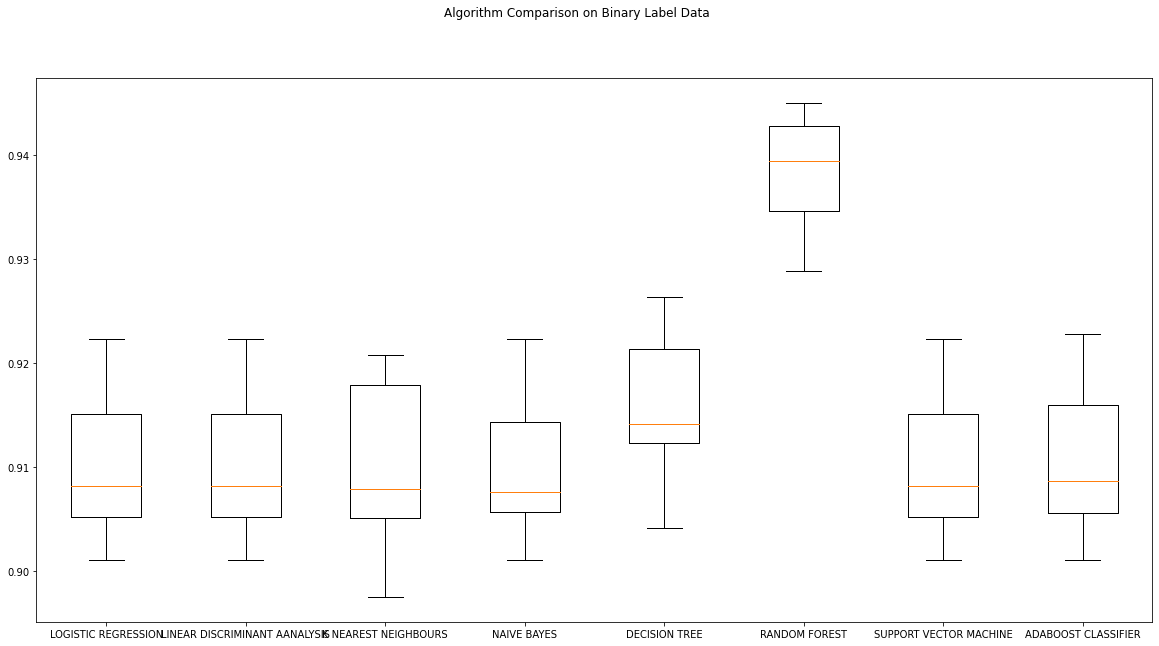

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Binary Label Data")

The Decision Tree, and by extension the Random Forest algorithm, appear to be the best performing models for the binary classification.

## AutoML

Automated machine learning (AutoML) involves automating the process of applying machine learning end-to-end. It makes ML accessible to non-experts as well as providing a quick and easy way to create model fitted on data without worrying about hyperparameters.

In [ ]:
try:
    import autosklearn.classification
except:
    os.kill(os.getpid(), 9)
import sklearn

# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Test Accuracy score 0.9305071915215746


## Nested Cross Validation

In [ ]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def nested_cross_val(X_train, y_train, model=KNeighborsClassifier()):

    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

    # define search space
    pgrid = {"n_neighbors": [5, 10, 30, 70, 100],
              "weights": ["uniform", "distance"],
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "leaf_size": [15, 30, 60, 90],
              "p": [1, 2, 4],
              }

    # define search
    search = GridSearchCV(model, pgrid, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    # execute the nested cross-validation
    scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#nested_cross_val(X_train, y_train)

# **Sklearn - Three-Label Data Classifier**

Let's now implement classifiers using a **WAKE / NREM / REM label** dataset.

First we'll create a three label set, indicating 0 for awake, 1 for non-REM sleep and 2 for REM sleep

In [ ]:
three_label_array = label_array.copy()
three_label_array[(three_label_array == 1) | (three_label_array == 2) | (three_label_array == 3)] = 1
three_label_array[three_label_array == 5] = 2

np.unique(three_label_array)

array([0, 1, 2])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(full_set_features, three_label_array, test_size=0.25)

## Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [full_set_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.84 (+/- 0.01)

The list of features with importance: 
['x', 'y', 'z', 'hr']
importance
 [0.29863282 0.29072605 0.26321252 0.14742861]


## Nested Cross Validation

In [ ]:
#nested_cross_val(X_train, y_train)

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.6858974842232286 0.02157488356951186



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set accuracy:
 0.6841786525359576 

Confusion Matrix
 [[   0  612    1]
 [   0 4519    0]
 [   0 1473    0]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       613
           1       0.68      1.00      0.81      4519
           2       0.00      0.00      0.00      1473

    accuracy                           0.68      6605
   macro avg       0.23      0.33      0.27      6605
weighted avg       0.47      0.68      0.56      6605
 

Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.6857460455558889 0.02164249039508671

Test set accuracy:
 0.6843300529901589 

Confusion Matrix
 [[   1  612    0]
 [   0 4519    0]
 [   0 1473    0]] 

Classification report
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       613
           1       0.68      1.00      0.81      4519
           2       0.00      0.00      0.00      1473

    accura

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.7128505871368311 0.01758383361029417

Test set accuracy:
 0.7235427706283118 

Confusion Matrix
 [[ 147  367   99]
 [ 149 4075  295]
 [  70  846  557]] 

Classification report
               precision    recall  f1-score   support

           0       0.40      0.24      0.30       613
           1       0.77      0.90      0.83      4519
           2       0.59      0.38      0.46      1473

    accuracy                           0.72      6605
   macro avg       0.59      0.51      0.53      6605
weighted avg       0.70      0.72      0.70      6605
 

Model  Mean Accuracy  95% conf interval
NAIVE BAYES: 0.6864020505600378 0.021782641715781276

Test set accuracy:
 0.6841786525359576 

Confusion Matrix
 [[   7  606    0]
 [   7 4512    0]
 [   1 1472    0]] 

Classification report
               precision    recall  f1-score   support

           0       0.47      0.01      0.02       613
           1       0.68      1.00 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
DECISION TREE: 0.8392382782753005 0.015114736715765721

Test set accuracy:
 0.8464799394398184 

Confusion Matrix
 [[ 320  216   77]
 [ 184 4115  220]
 [  69  248 1156]] 

Classification report
               precision    recall  f1-score   support

           0       0.56      0.52      0.54       613
           1       0.90      0.91      0.90      4519
           2       0.80      0.78      0.79      1473

    accuracy                           0.85      6605
   macro avg       0.75      0.74      0.74      6605
weighted avg       0.84      0.85      0.85      6605
 

Model  Mean Accuracy  95% conf interval
RANDOM FOREST: 0.8768926904482595 0.01518359091505648

Test set accuracy:
 0.883118849356548 

Confusion Matrix
 [[ 318  225   70]
 [  77 4284  158]
 [  17  225 1231]] 

Classification report
               precision    recall  f1-score   support

           0       0.77      0.52      0.62       613
           1       0.90      0.95      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.6902380128883322 0.025346433637905987

Test set accuracy:
 0.6840272520817563 

Confusion Matrix
 [[  14  581   18]
 [  13 4471   35]
 [   5 1435   33]] 

Classification report
               precision    recall  f1-score   support

           0       0.44      0.02      0.04       613
           1       0.69      0.99      0.81      4519
           2       0.38      0.02      0.04      1473

    accuracy                           0.68      6605
   macro avg       0.50      0.34      0.30      6605
weighted avg       0.60      0.68      0.57      6605
 



## Plotting Algorithm Performance

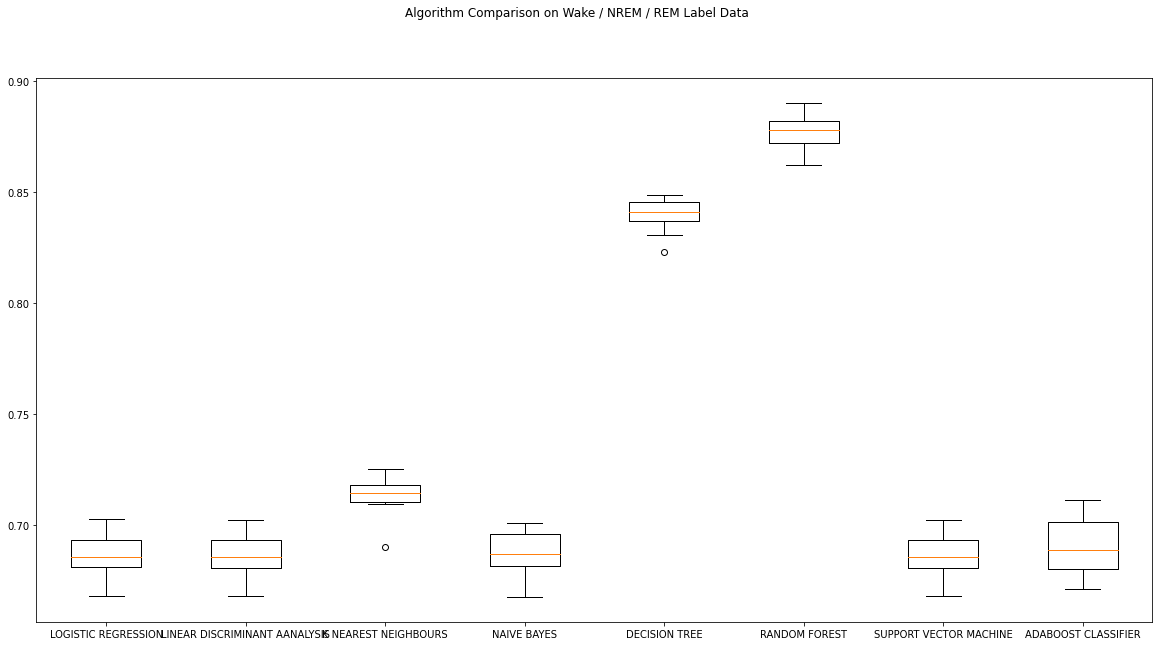

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake / NREM / REM Label Data")

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.8737320211960636


# **Sklearn - Multi-Label Data Classifier**

Let's now implement a simple multiclass classifier using our **original multi-label** dataset

In [ ]:
np.unique(label_array)

array([0, 1, 2, 3, 5])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.
# Please don't ever train on your test data, that's a big no no!
X_train, X_test, y_train, y_test = train_test_split(full_set_features, label_array, test_size=0.25)

## Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [full_set_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.73 (+/- 0.01)

The list of features with importance: 
['x', 'y', 'z', 'hr']
importance
 [0.31712087 0.2890046  0.23943127 0.15444326]


## Nested Cross Validation

In [ ]:
#nested_vs_non_plot(X_train, y_train, title="Non-Nested and Nested Cross Validation on Multi-label Sleep Stage Dataset")

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.48198063235449184 0.03159891520683793



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set accuracy:
 0.49825889477668434 

Confusion Matrix
 [[   0    0  577    0   29]
 [   0    0  423    0    9]
 [   0    0 3271    0   44]
 [   0    0  789    0   13]
 [   0    0 1430    0   20]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       606
           1       0.00      0.00      0.00       432
           2       0.50      0.99      0.67      3315
           3       0.00      0.00      0.00       802
           5       0.17      0.01      0.03      1450

    accuracy                           0.50      6605
   macro avg       0.14      0.20      0.14      6605
weighted avg       0.29      0.50      0.34      6605
 

Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.4853623805567625 0.031239318970133476

Test set accuracy:
 0.5012869038607116 

Confusion Matrix
 [[   1    0  591   13    1]
 [   0    0  429    2    1]
 [   0    0 3308    7    0]
 [   0    0  802    0    0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.57742792145972 0.020640964418937053

Test set accuracy:
 0.6012112036336109 

Confusion Matrix
 [[ 173   32  255   50   96]
 [  57   39  254   18   64]
 [ 110   95 2639  193  278]
 [  19    5  234  518   26]
 [ 109   33  599  107  602]] 

Classification report
               precision    recall  f1-score   support

           0       0.37      0.29      0.32       606
           1       0.19      0.09      0.12       432
           2       0.66      0.80      0.72      3315
           3       0.58      0.65      0.61       802
           5       0.56      0.42      0.48      1450

    accuracy                           0.60      6605
   macro avg       0.47      0.45      0.45      6605
weighted avg       0.57      0.60      0.58      6605
 

Model  Mean Accuracy  95% conf interval
NAIVE BAYES: 0.48435284037916204 0.030092458916894643

Test set accuracy:
 0.5018925056775171 

Confusion Matrix
 [[  22    0  578    6    0]
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
DECISION TREE: 0.7356655889884274 0.01643129564884275

Test set accuracy:
 0.743224829674489 

Confusion Matrix
 [[ 298   81  129   24   74]
 [  70  130  175    5   52]
 [  95  183 2728  149  160]
 [  11    4  132  646    9]
 [  75   59  192   17 1107]] 

Classification report
               precision    recall  f1-score   support

           0       0.54      0.49      0.52       606
           1       0.28      0.30      0.29       432
           2       0.81      0.82      0.82      3315
           3       0.77      0.81      0.79       802
           5       0.79      0.76      0.78      1450

    accuracy                           0.74      6605
   macro avg       0.64      0.64      0.64      6605
weighted avg       0.74      0.74      0.74      6605
 

Model  Mean Accuracy  95% conf interval
RANDOM FOREST: 0.7961332456520599 0.016926942531477945

Test set accuracy:
 0.7990915972747918 

Confusion Matrix
 [[ 310   64  135   19   78]
 [  52 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.5014636524276286 0.020660085347764347

Test set accuracy:
 0.5196063588190765 

Confusion Matrix
 [[  28    0  527    8   43]
 [  16    0  389    4   23]
 [   5    0 3206   32   72]
 [   0    0  681   89   32]
 [   9    0 1302   30  109]] 

Classification report
               precision    recall  f1-score   support

           0       0.48      0.05      0.08       606
           1       0.00      0.00      0.00       432
           2       0.53      0.97      0.68      3315
           3       0.55      0.11      0.18       802
           5       0.39      0.08      0.13      1450

    accuracy                           0.52      6605
   macro avg       0.39      0.24      0.22      6605
weighted avg       0.46      0.52      0.40      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plotting Algorithm Performance

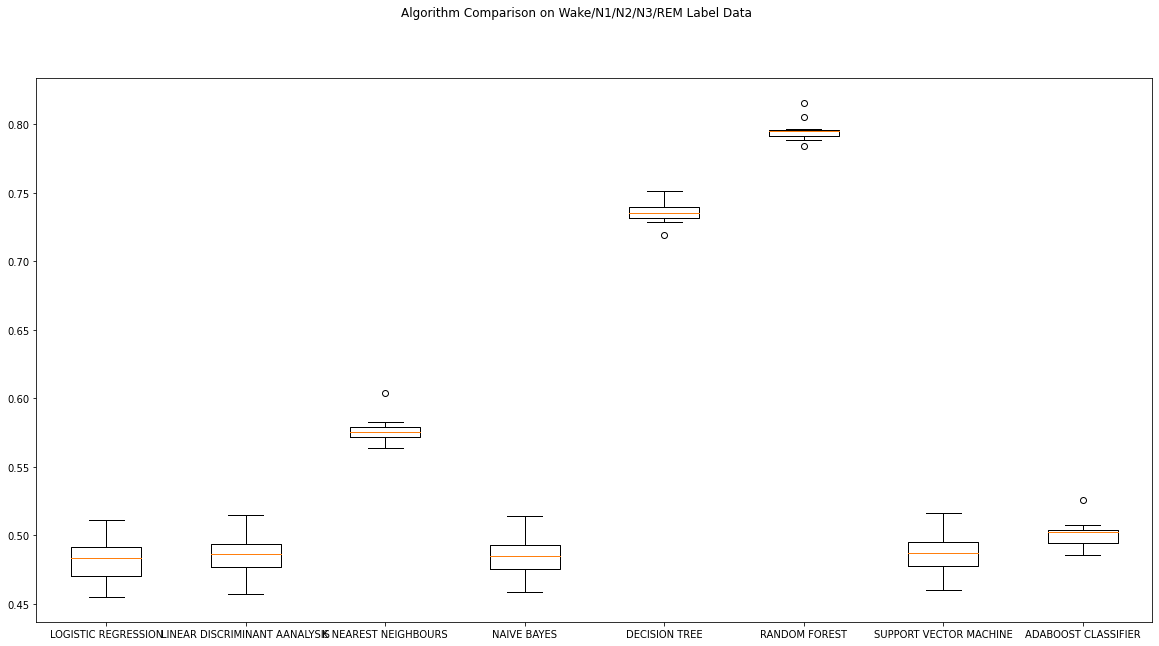

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake/N1/N2/N3/REM Label Data")

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.7146101438304315


#Extracted features

We will now be performing classification on the extracted feature dataset and observing the model results. Again, we will perform classification with the three different label sets of Binary: Wake/Sleep, three classes: Wake, Non-REM Sleep and REM Sleep and finally with all original labels of sleep classes (0, 1, 2, 3, 5). 

In [ ]:
import pandas as pd
import numpy as np

extracted_features = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features.csv')
extracted_labels = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_labels.csv')

extracted_features = extracted_features.rename(columns={'Unnamed: 0': 'id', 'Unnamed: 1': 'time'})

extracted_features.head()

,id,time,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__absolute_sum_of_changes,value__longest_strike_below_mean,value__longest_strike_above_mean,value__count_above_mean,value__count_below_mean,value__last_location_of_maximum,value__first_location_of_maximum,value__last_location_of_minimum,value__first_location_of_minimum,value__percentage_of_reoccurring_values_to_all_values,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__sum_of_reoccurring_values,value__sum_of_reoccurring_data_points,value__ratio_value_number_to_time_series_length,value__maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__c3__lag_1,...,"value__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",value__number_crossing_m__m_0,value__number_crossing_m__m_-1,value__number_crossing_m__m_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_2,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,value__energy_ratio_by_chunks__num_segments_10__segment_focus_5,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,value__energy_ratio_by_chunks__num_segments_10__segment_focus_7,value__energy_ratio_by_chunks__num_segments_10__segment_focus_8,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,value__ratio_beyond_r_sigma__r_0.5,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_1.5,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_2.5,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__ratio_beyond_r_sigma__r_10,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_5,value__lempel_ziv_complexity__bins_10,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1
0,46343,390.0,1.0,0.0,0.0,0.0,89.910614,8100.838344,30.793696,30.186508,22.242584,0.235069,22.477653,4.0,38.986724,1.734466,1519.964679,1.999177,3.997235,92.381088,3.0,1.0,1.0,3.0,1.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,1.0,90.0,-0.559524,-0.220047,-892.340880,0.0,0.0,-6.802985,...,-0.286355,0.927415,0.0,3.0,0.0,1.0,0.000039,0.000059,0.000006,0.999897,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.75,0.75,0.75,0.75,1.0,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.0
1,46343,420.0,1.0,0.0,0.0,0.0,100.727615,10201.949516,34.534958,33.877009,25.002583,0.179321,25.181904,4.0,43.776239,1.738401,1916.359096,1.999278,3.997573,103.604874,3.0,1.0,1.0,3.0,1.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,1.0,101.0,-0.631027,0.240954,-1602.303277,0.0,0.0,-10.606410,...,-0.318167,0.922892,0.0,3.0,0.0,1.0,0.000039,0.000044,0.000010,0.999907,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.75,0.75,0.75,0.75,1.0,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.0
2,46343,450.0,1.0,0.0,0.0,0.0,93.513177,8465.342833,30.757888,30.705180,22.563936,0.814358,23.378294,4.

##Binary Data Classifier

In [ ]:
# first we'll create a binary label set, indicating 0 for awake and 1 for asleep

e_binary_label_array = extracted_labels['1'].ravel().copy()
e_binary_label_array[e_binary_label_array > 0] = 1
print(np.unique(e_binary_label_array))
print(e_binary_label_array.shape)

[0 1]
(26417,)


In [ ]:
print("Extracted Features", "\n", extracted_features)
print("\nExtracted Labels", "\n", e_binary_label_array)

Extracted Features 
             id  ...  value__permutation_entropy__dimension_4__tau_1
0        46343  ...                                            -0.0
1        46343  ...                                            -0.0
2        46343  ...                                            -0.0
3        46343  ...                                            -0.0
4        46343  ...                                            -0.0
...        ...  ...                                             ...
26412  9961348  ...                                            -0.0
26413  9961348  ...                                            -0.0
26414  9961348  ...                                            -0.0
26415  9961348  ...                                            -0.0
26416  9961348  ...                                            -0.0

[26417 rows x 271 columns]

Extracted Labels 
 [0 0 0 ... 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(extracted_features, e_binary_label_array, test_size=0.25)

### Decision Tree Classifier
Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
#print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.94 (+/- 0.01)

The list of features with importance: 
['id', 'time', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change', 'value__mean_second_derivative_central', 'value__median', 'value__mean', 'value__standard_deviation', 'value__variation_coefficient', 'value__variance', 'value__skewness', 'value__kurtosis', 'value__absolute_sum_of_changes', 'value__maximum', 'value__minimum', 'value__benford_correlation', 'value__time_reversal_asymmetry_statistic__lag_1', 'value__c3__lag_1', 'value__cid_ce__normalize_True', 'value__cid_ce__normalize_False', 'value__quantile__q_0.1', 'value__quantile__q_0.2', 'value__quantile__q_0.3', 'value__quantile__q_0.4', 'value__quantile__q_0.6', 'value__quantile__q_0.7', 'value__quantile__q_0.9', 'value__autocorrelation__lag_1', 'value__autocorrelation__lag_2', 'value__autocorrelation__lag_3', 'value__agg_autocorrelation__f_agg_"

###Nested Cross-Validation
We intended to include the nested validation for the model through sklearn but it won't co-operate in CoLab and ends up running for too long with no result.

In [ ]:
#nested_cross_val(X_train, y_train)

###Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.9080363605615608 0.018370744609273782



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test set accuracy:
 0.9077971233913702 

Confusion Matrix
 [[   1  607]
 [   2 5995]] 

Classification report
               precision    recall  f1-score   support

           0       0.33      0.00      0.00       608
           1       0.91      1.00      0.95      5997

    accuracy                           0.91      6605
   macro avg       0.62      0.50      0.48      6605
weighted avg       0.86      0.91      0.86      6605
 

Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.9083392124272415 0.01899483947408386

Test set accuracy:
 0.9084027252081757 

Confusion Matrix
 [[   3  605]
 [   0 5997]] 

Classification report
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       608
           1       0.91      1.00      0.95      5997

    accuracy                           0.91      6605
   macro avg       0.95      0.50      0.48      6605
weighted avg       0.92      0.91      0.87      6605
 

Model  Me

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.929033334335114 0.01363453017124775

Test set accuracy:
 0.9262679788039364 

Confusion Matrix
 [[ 186  422]
 [  65 5932]] 

Classification report
               precision    recall  f1-score   support

           0       0.74      0.31      0.43       608
           1       0.93      0.99      0.96      5997

    accuracy                           0.93      6605
   macro avg       0.84      0.65      0.70      6605
weighted avg       0.92      0.93      0.91      6605
 



###Plotting Algorithm Performance

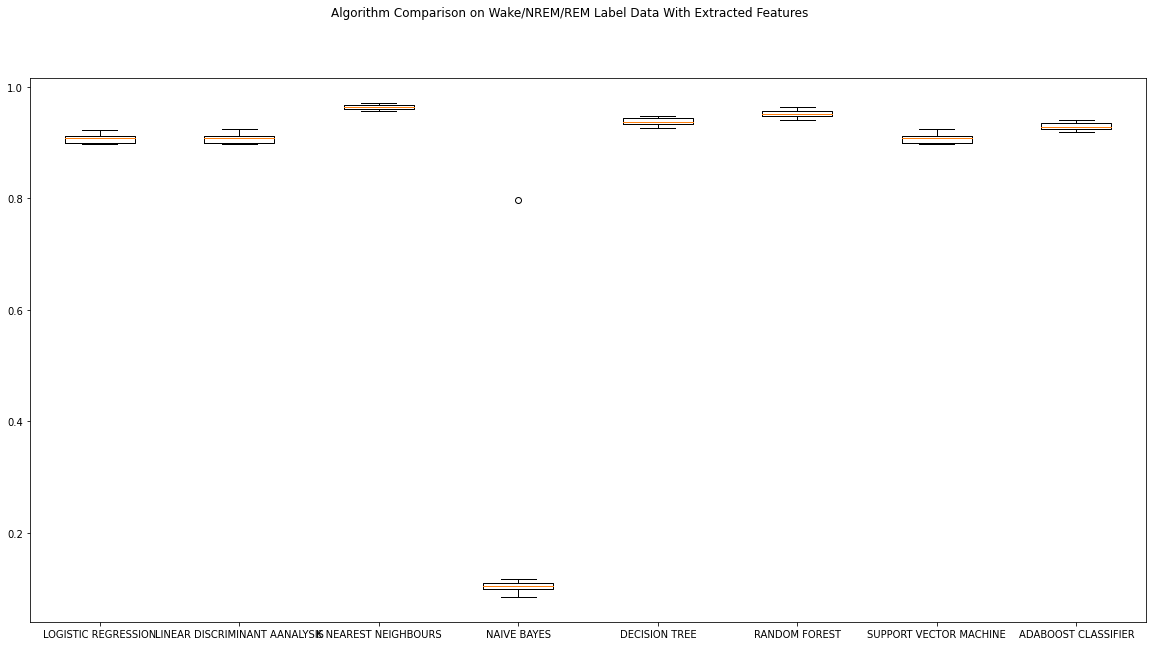

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake/NREM/REM Label Data With Extracted Features")

###AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

[WARNING] [2020-11-20 01:23:55,425:AutoML(1):79eac1985468343644b3deadbf03faf9] No valid ensemble was created. Please check the logfile for errors. Default to the best individual estimator:[(1, 3, 0.0)]
Test Accuracy score 0.9517032551097653


##Three-Label Classifier
Now we are using the extracted feature set to classify based on the three label categories of Wake/Non-REM Sleep/REM Sleep and again assigning them the labels of 0/1/2 respectively

In [ ]:
e_three_label_array = extracted_labels['1'].ravel().copy()
e_three_label_array[(e_three_label_array == 1) | (e_three_label_array == 2) | (e_three_label_array == 3)] = 1
e_three_label_array[e_three_label_array == 5] = 2

print(np.unique(three_label_array))
print(three_label_array.shape)

[0 1 2]
(26417,)


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(extracted_features, e_three_label_array, test_size=0.25)

###Decision Tree Classifier

##Multi-Label Classifier

In [ ]:
e_label_array = extracted_labels['1'].ravel()
print(e_label_array.shape)
np.unique(e_label_array)

(26417,)


array([0, 1, 2, 3, 5])

In [ ]:
extracted_features = extracted_features.dropna(axis='columns')
extracted_labels["1"].unique()

array([0, 1, 2, 3, 5])

In [ ]:
print("Extracted Features", "\n", extracted_features)
print("\nExtracted Labels", "\n", extracted_labels)

Extracted Features 
             id  ...  value__permutation_entropy__dimension_4__tau_1
0        46343  ...                                            -0.0
1        46343  ...                                            -0.0
2        46343  ...                                            -0.0
3        46343  ...                                            -0.0
4        46343  ...                                            -0.0
...        ...  ...                                             ...
26412  9961348  ...                                            -0.0
26413  9961348  ...                                            -0.0
26414  9961348  ...                                            -0.0
26415  9961348  ...                                            -0.0
26416  9961348  ...                                            -0.0

[26417 rows x 271 columns]

Extracted Labels 
             id   time  1
0        46343    390  0
1        46343    420  0
2        46343    450  0
3        46343 

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(extracted_features, e_label_array, test_size=0.25)

### Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
#print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.79 (+/- 0.01)

The list of features with importance: 
['id', 'time', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change', 'value__mean_second_derivative_central', 'value__median', 'value__mean', 'value__standard_deviation', 'value__variation_coefficient', 'value__variance', 'value__skewness', 'value__kurtosis', 'value__absolute_sum_of_changes', 'value__last_location_of_minimum', 'value__first_location_of_minimum', 'value__maximum', 'value__minimum', 'value__benford_correlation', 'value__time_reversal_asymmetry_statistic__lag_1', 'value__c3__lag_1', 'value__cid_ce__normalize_True', 'value__cid_ce__normalize_False', 'value__quantile__q_0.1', 'value__quantile__q_0.2', 'value__quantile__q_0.3', 'value__quantile__q_0.4', 'value__quantile__q_0.6', 'value__quantile__q_0.7', 'value__quantile__q_0.8', 'value__quantile__q_0.9', 'value__autocorrelation__lag_1', 'valu

### Nested Cross Validation

In [ ]:
#nested_cross_val(X_train, y_train)

### Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.4878349109680206 0.03250920578693714



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set accuracy:
 0.4908402725208176 

Confusion Matrix
 [[   0    0  583    0    0]
 [   0    0  447    0    6]
 [   0    0 3229    0   20]
 [   0    0  852    0    0]
 [   0    0 1455    0   13]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       583
           1       0.00      0.00      0.00       453
           2       0.49      0.99      0.66      3249
           3       0.00      0.00      0.00       852
           5       0.33      0.01      0.02      1468

    accuracy                           0.49      6605
   macro avg       0.17      0.20      0.14      6605
weighted avg       0.32      0.49      0.33      6605
 

Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.4973746555954627 0.029281477360554656

Test set accuracy:
 0.5000757002271007 

Confusion Matrix
 [[  11    1  563    1    7]
 [   4    1  443    0    5]
 [   1    0 3234    2   12]
 [   1    0  833   18    0]
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.5116090753174329 0.024877466042759044

Test set accuracy:
 0.5129447388342165 

Confusion Matrix
 [[ 171   17  280   15  100]
 [  45    2  306   17   83]
 [  72   11 2552  171  443]
 [  13    0  520  251   68]
 [   0    1 1015   40  412]] 

Classification report
               precision    recall  f1-score   support

           0       0.57      0.29      0.39       583
           1       0.06      0.00      0.01       453
           2       0.55      0.79      0.64      3249
           3       0.51      0.29      0.37       852
           5       0.37      0.28      0.32      1468

    accuracy                           0.51      6605
   macro avg       0.41      0.33      0.35      6605
weighted avg       0.47      0.51      0.47      6605
 



### Plotting Algorithm Performance

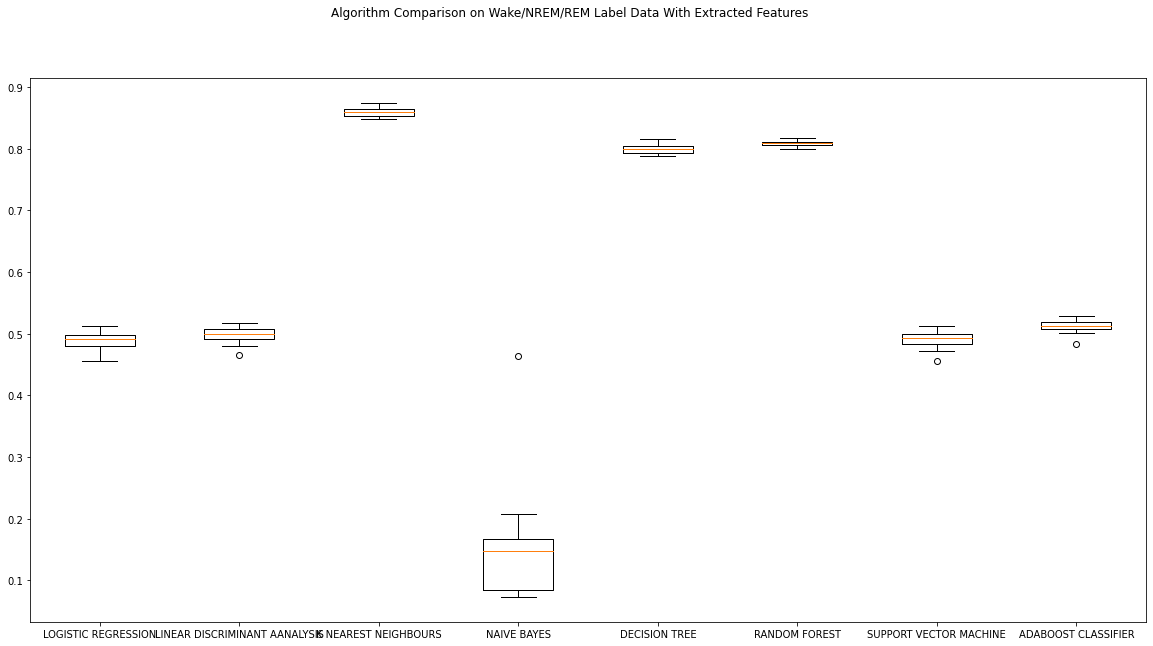

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake/NREM/REM Label Data With Extracted Features")

### AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.0882664647993944


### PCA of Extracted Features

Principal Component Analysis is often used in ML when the number of dimensions is very high. The much smaller number of Principal Components capture the majority of the variance in the original dataset, and thus can be used to train the model instead. The smaller number of dimensions with PCA means faster training times and simplified data structure when feeding into ML models.

Conversely, the Principal Components created from reducing the original dimensions have no interpretability to the user, as we cannot trace back what makes up each PC. Therefore, any model created using PCA will not be very transparent, making it a poor choice for solving real-world high-stakes problems.

In [ ]:
feats = extracted_features.columns[2:]
feats

Index(['value__variance_larger_than_standard_deviation',
       'value__has_duplicate_max', 'value__has_duplicate_min',
       'value__has_duplicate', 'value__sum_values', 'value__abs_energy',
       'value__mean_abs_change', 'value__mean_change',
       'value__mean_second_derivative_central', 'value__median',
       ...
       'value__lempel_ziv_complexity__bins_5',
       'value__lempel_ziv_complexity__bins_10',
       'value__lempel_ziv_complexity__bins_100',
       'value__fourier_entropy__bins_2', 'value__fourier_entropy__bins_3',
       'value__fourier_entropy__bins_5', 'value__fourier_entropy__bins_10',
       'value__fourier_entropy__bins_100',
       'value__permutation_entropy__dimension_3__tau_1',
       'value__permutation_entropy__dimension_4__tau_1'],
      dtype='object', length=269)

In [ ]:
from scipy import stats

standardised = stats.zscore(extracted_features[feats])

details = extracted_features.columns[:2]
df1_std = pd.DataFrame(standardised, columns = feats)
df1_std = df1_std.dropna(axis='columns')
#df1_std = pd.concat([extracted_features[details], df1_std], axis=1)
df1_std

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__absolute_sum_of_changes,value__last_location_of_minimum,value__first_location_of_minimum,value__maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__c3__lag_1,value__cid_ce__normalize_True,value__cid_ce__normalize_False,value__quantile__q_0.1,value__quantile__q_0.2,value__quantile__q_0.3,value__quantile__q_0.4,value__quantile__q_0.6,value__quantile__q_0.7,value__quantile__q_0.8,value__quantile__q_0.9,value__autocorrelation__lag_1,value__autocorrelation__lag_2,value__autocorrelation__lag_3,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",value__partial_autocorrelation__lag_1,value__number_cwt_peaks__n_1,value__number_peaks__n_1,value__binned_entropy__max_bins_10,...,"value__fft_coefficient__attr_""abs""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_1","value__fft_coefficient__attr_""abs""__coeff_2","value__fft_coefficient__attr_""angle""__coeff_1","value__fft_aggregated__aggtype_""centroid""","value__fft_aggregated__aggtype_""variance""","value__fft_aggregated__aggtype_""skew""","value__fft_aggregated__aggtype_""kurtosis""",value__value_count__value_0,value__value_count__value_1,value__range_count__max_1__min_-1,value__range_count__max_1000000000000.0__min_0,value__friedrich_coefficients__coeff_0__m_3__r_30,value__friedrich_coefficients__coeff_1__m_3__r_30,value__friedrich_coefficients__coeff_2__m_3__r_30,value__friedrich_coefficients__coeff_3__m_3__r_30,value__max_langevin_fixed_point__m_3__r_30,"value__linear_trend__attr_""pvalue""","value__linear_trend__attr_""rvalue""","value__linear_trend__attr_""intercept""","value__linear_trend__attr_""slope""","value__linear_trend__attr_""stderr""","value__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""",value__number_crossing_m__m_0,value__number_crossing_m__m_-1,value__number_crossing_m__m_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_2,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1
0,2.575756,2.821527,2.563929,2.574612,2.389934,0.678840,2.575756,2.515752,-0.835504,2.795317,0.709471,0.700269,2.563929,-2.485073,-2.485073,2.533013,0.825217,-0.621031,0.082009,-0.582327,-0.203491,2.501582,0.665751,0.371718,0.079868,0.291610,0.936568,2.677247,2.577357,2.546539,-0.025365,0.813961,-1.494746,-1.054467,0.813961,1.395581,-0.025365,0.780527,1.013760,-1.0,...,2.575756,2.463885,2.602619,0.800593,-0.076038,1.260173,0.074574,-0.158207,-0.006153,-0.006153,0.077322,0.009425,0.017373,-0.006344,-0.012000,0.005699,0.007450,-0.798195,0.798195,-2.510599,2.560623,2.438505,0.029030,1.061956,1.294470,-0.063096,-0.018211,0.099459,0.020001,-1.649423,1.898409,0.009425,-0.009477,1.509692,0.695654,1.0,1.0,1.0,1.0,0.243792
1,3.639897,4.361842,3.667110,3.670183,3.483406,0.486899,3.639897,3.611803,-0.697872,4.340198,0.850319,0.842304,3.667110,-2.485073,-2.485073,3.621965,0.531841,1.075842,-0.403956,-1.029758,-0.193166,3.596822,0.296412,-0.018904,-0.274987,0.002243,0.838773,3.673564,3.657761,3.633384,-0.019141,0.751283,-1.388319,-0.981523,0.751283,1.291465,-0.019141,0.780527,1.013760,-1.0,...,3.639897,3.558150,3.695714,0.745423,-0.018201,1.122919,0.016814,-0.0926

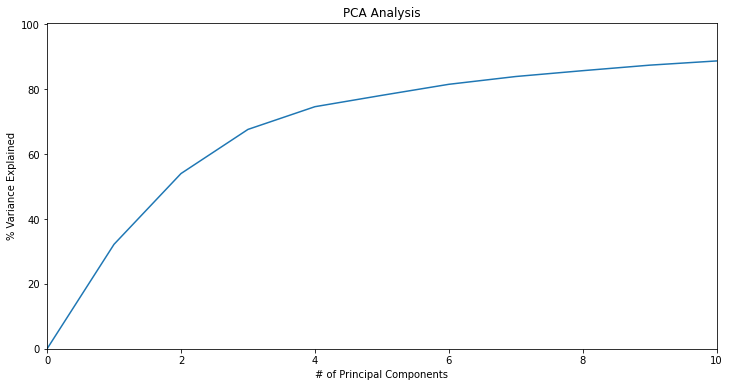

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# use this function to find variance captured in n PCs
# ideally we'd like 75-90% variance captured in 2 or 3 PCs
# to give an accurate representation of the original data

def ideal_pca(df_std):
    dims = 10 # or use len(df_std.columns)
    pca = PCA(n_components = dims)
    pca.fit(df_std)
    variance = pca.explained_variance_ratio_
    variance = np.insert(variance, 0, 0, axis=0)
    var = np.cumsum(np.round(variance, 3)*100)
    plt.figure(figsize=(12,6))
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Principal Components')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.xlim(0, dims)
    plt.plot(var)
    
ideal_pca(df1_std)

In [ ]:
pca3 = PCA(n_components = 5).fit(df1_std)
pca3d = pca3.transform(df1_std)
pca3d_df = pd.DataFrame(pca3d)

print(pca3.explained_variance_ratio_)
print("\nTotal variance captured:\n")
print(sum(pca3.explained_variance_ratio_))

# the % variance captured by our PCs

[0.32182321 0.21781189 0.13619469 0.0699446  0.0350436 ]

Total variance captured:

0.7808179870173954


In [ ]:
pca3d_df

,0,1,2,3,4
0,16.479781,2.196632,0.555395,-4.694193,1.827687
1,23.148063,1.351246,-0.376630,-4.838082,1.933854
2,18.213829,7.570060,5.841912,-3.278936,6.812944
3,11.664291,9.782295,-2.254102,-3.964441,3.505585
4,12.299023,9.864997,-2.051454,-3.971385,3.628090
...,...,...,...,...,...
26412,3.462305,-4.156793,-2.779734,-1.325572,0.161440
26413,5.243921,-3.735498,0.654760,-1.911027,-1.356352
26414,1.330057,-3.492736,0.889212,-2.119469,-1.253957
26415,1.926167,-3.536070,0.846977,-2.105734,-1.295858


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.
# Please don't ever train on your test data, that's a big no no!
X_train, X_test, y_train, y_test = train_test_split(pca3d_df, e_label_array, test_size=0.25)

### Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.69 (+/- 0.01)

The list of features with importance: 
['id', 'time', 'value__variance_larger_than_standard_deviation', 'value__has_duplicate_max', 'value__has_duplicate_min']
importance
 [0.15965157 0.16852435 0.23174282 0.20846372 0.23161754]


### AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.7494322482967449
